<h1><b>Identification of Certain entities of each events from the dataset

<h3><b>Import requried libraries

In [1]:
import pandas as pd
import string
import re
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from mlxtend.frequent_patterns import apriori,association_rules
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import preprocessor as p
from scipy.stats import entropy
from math import log2
import matplotlib.pyplot as plt
import seaborn as sns

nlp = spacy.load('en_core_web_sm')
stopword = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
%matplotlib inline

/root/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<h3><b>Load twitter dataset from kaggle

In [2]:
df = pd.read_csv('datasets_corona_May_Tweets.csv',engine='python')

In [3]:
df=df[['created_at','text']]

In [4]:
#Identify Unique hashtags
utags = []
def getTags(x):
    tag = " ".join([str(i)  for i in x.split() if i.startswith("#") ])
    for i in x.split():
        if i.startswith("#"):
            if i not in utags:
                utags.append(i)
    return(tag)

In [5]:
df['hashTag'] = df['text'].apply(lambda x:getTags(x))
df['date'] = pd.to_datetime(df['created_at'])

In [6]:
pts = df['text'].apply(lambda x: len(x.split()))
hashPerTweet = df['hashTag'].apply(lambda x: len(x.split(' ')))

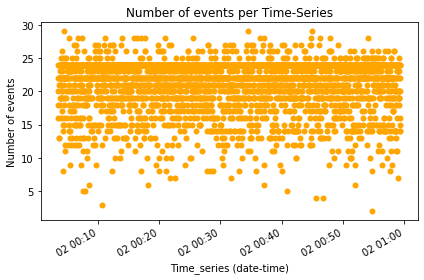

In [9]:
import matplotlib
dates = matplotlib.dates.date2num(df['date'])
plt.plot_date(dates, pts,mfc='orange',mew=0.0000001)
plt.gcf().autofmt_xdate()
plt.title('Number of events per Time-Series')
plt.ylabel('Number of events')
plt.xlabel('Time_series (date-time)')
plt.tight_layout()

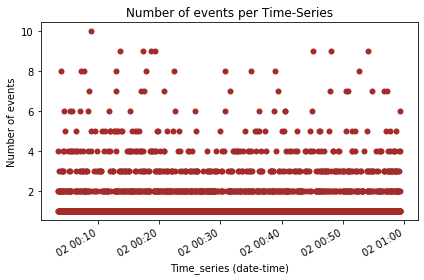

In [10]:
dates = matplotlib.dates.date2num(df['date'])
plt.plot_date(dates, hashPerTweet,mfc='brown',mew=0.0000001)
plt.gcf().autofmt_xdate()
plt.title('Number of events per Time-Series')
plt.ylabel('Number of events')
plt.xlabel('Time_series (date-time)')
plt.tight_layout()

In [13]:
no_tweets =(len(df))
no_tags = len(utags)
staring_dateTime = '2020-05-02 00:59'
ending_dateTime = '2020-05-02 00:03'

In [14]:
clean_data =df['text'].apply(lambda x: p.clean(x))

In [15]:
# data clean methods
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    #after tweepy preprocessing the colon symbol left remain after   
    tweet = re.sub(r':', '', text_rc)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    #filter using NLTK library append it to a string
    tokens = re.split('\W+', tweet)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text

def clean_textWithoutSteam(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    #after tweepy preprocessing the colon symbol left remain after    
    tweet = re.sub(r':', '', text_rc)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    #filter using NLTK library append it to a string
    tokens = re.split('\W+', tweet)    # tokenization
    text = [word for word in tokens if word not in stopword]  # remove stopwords
    return text

<h3><b>Create Dataframe of DTM of with stemming and without stemming

In [17]:
#example data collection
ex = []
ex.append(clean_data[2])
ex.append(clean_data[7])
ex.append(clean_data[27])
example = pd.DataFrame(ex)

In [18]:
def countVect(text):
    countVectorizer = CountVectorizer(token_pattern=r"(?u)\b+\b",analyzer=clean_textWithoutSteam,stop_words=None) 
    countVector = countVectorizer.fit_transform(text)
    dtm = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())
    
    countVectorizer1 = CountVectorizer(token_pattern=r"(?u)\b\w+\b",analyzer=clean_text,stop_words=None) 
    countVector1 = countVectorizer1.fit_transform(text)
    dtm1 = pd.DataFrame(countVector1.toarray(), columns=countVectorizer1.get_feature_names())
    
    return (dtm,dtm1)

df_withoutStem, df_withStem = countVect(clean_data)

In [19]:
#example data frame
df_exWithoutStem, df_exWithStem = countVect(example[0])

In [20]:
no_wordsTweets = df_withoutStem.sum(axis=1).sum()//3116
no_wordsDataset = len(df_withoutStem.columns)

In [21]:
info = pd.DataFrame([no_tweets,no_tags,no_wordsTweets,no_wordsDataset,staring_dateTime,ending_dateTime],index=['Number of Tweets',
                                                                                                               'Number of Unique Hashtags',
                                                                                                               'Average words per tweets',
                                                                                                               'Total number of words in dataset',
                                                                                                               'Starting dateTime','Ending dateTime'],
                   columns=['Dataset Details'])

In [22]:
#Dataset detailed information
info

,Dataset Details
Number of Tweets,3116
Number of Unique Hashtags,939
Average words per tweets,10
Total number of words in dataset,4729
Starting dateTime,2020-05-02 00:59
Ending dateTime,2020-05-02 00:03


<h3><b> Get Association of stemmed tweets and without stemmed tweets

In [23]:
def getAssociation(dtm1,dtm):
    def encode_units(x):
        if x <= 0:
            return 0
        if x >= 1:
            return 1

    word_sets_withStem = dtm1.iloc[:,1:].applymap(encode_units)
    word_sets_withoutStem = dtm.iloc[:,1:].applymap(encode_units)
    
    prob_words_withStem = apriori(word_sets_withStem,min_support=0.01,verbose=1,use_colnames=True)
    prob_words_withoutStem = apriori(word_sets_withoutStem,min_support=0.01,verbose=1,use_colnames=True)
    
    rules_withStem = association_rules(prob_words_withStem,min_threshold=0)
    rules_withoutStem = association_rules(prob_words_withoutStem,min_threshold=0)
    
    return(rules_withStem,rules_withoutStem)

In [24]:
rules_withStem, rules_withoutStem = getAssociation(df_withStem,df_withoutStem)

Processing 48 combinations | Sampling itemset size 12116
Processing 48 combinations | Sampling itemset size 12116


In [25]:
#example data
rules_exwithStem, rules_exwithoutStem = getAssociation(df_exWithStem,df_exWithoutStem)

Processing 18 combinations | Sampling itemset size 65
Processing 14 combinations | Sampling itemset size 75


In [26]:
#example data
asso_exwithStem = rules_exwithStem[['antecedents','consequents','support','confidence']]
asso_exwithoutStem = rules_exwithoutStem[['antecedents','consequents','support','confidence']]

asso_exwithStem.columns = pd.MultiIndex.from_product([['With_Stemming'], asso_exwithStem.columns])
asso_exwithoutStem.columns = pd.MultiIndex.from_product([['Without_Stemming'], asso_exwithoutStem.columns])

result_ex = pd.concat([asso_exwithStem, asso_exwithoutStem], axis = 1)

In [27]:
#rules_withoutStem.head()

In [28]:
asso_withStem = rules_withStem[['antecedents','consequents','support','confidence']]
asso_withoutStem = rules_withoutStem[['antecedents','consequents','support','confidence']]

asso_withStem.columns = pd.MultiIndex.from_product([['With_Stemming'], asso_withStem.columns])
asso_withoutStem.columns = pd.MultiIndex.from_product([['Without_Stemming'], asso_withoutStem.columns])

result = pd.concat([asso_withStem, asso_withoutStem], axis = 1)

In [29]:
result.head()
#support = Probability
#confidence = Conditinal Probability

With_Stemming                                    Without_Stemming  \
    antecedents   consequents   support confidence      antecedents   
0         (ago)      (consid)  0.049743   0.933735            (ago)   
1      (consid)         (ago)  0.049743   0.981013       (consider)   
2         (ago)  (conspiraci)  0.049743   0.933735            (ago)   
3  (conspiraci)         (ago)  0.049743   0.987261     (conspiracy)   
4         (ago)        (fact)  0.049743   0.933735            (ago)   

                                      
    consequents   support confidence  
0    (consider)  0.049743   0.933735  
1         (ago)  0.049743   0.993590  
2  (conspiracy)  0.049743   0.933735  
3         (ago)  0.049743   0.987261  
4       (facts)  0.049743   0.933735

In [30]:
def getRanks(x,y):
    rank = x.sort_values('confidence',axis = 0, ascending = False, inplace = False)[['antecedents','consequents','confidence']]
    rank.reset_index(drop=True,inplace=True)
    rank['rank'] = rank.index.values
    col = rank.columns.tolist()
    col = col[-1:] + col[:-1]
    
    rank1 = y.sort_values('confidence',axis = 0, ascending = False, inplace = False)[['antecedents','consequents','confidence']]
    rank1.reset_index(drop=True,inplace=True)
    rank1['rank'] = rank1.index.values
    
    return(rank[col],rank1[col])

In [31]:
rank_asso_withStem, rank_asso_withoutStem = getRanks(rules_withStem, rules_withoutStem)

In [32]:
#examle data
rank_asso_exwithStem, rank_asso_exwithoutStem = getRanks(rules_exwithStem, rules_exwithoutStem)
rank_asso_exwithStem.columns = pd.MultiIndex.from_product([['With_Stemming'], rank_asso_exwithStem.columns])
rank_asso_exwithoutStem.columns = pd.MultiIndex.from_product([['Without_Stemming'], rank_asso_exwithoutStem.columns])

rank_asso_exresult = pd.concat([rank_asso_exwithStem, rank_asso_exwithoutStem], axis = 1)

In [33]:
#example df
rank_asso_exresult.head(5)

With_Stemming                                                  \
           rank           antecedents    consequents confidence   
0           0.0              (govern)    (bioweapon)        1.0   
1           1.0           (bioweapon)       (govern)        1.0   
2           2.0  (relat, new, report)         (toll)        1.0   
3           3.0   (toll, new, report)        (relat)        1.0   
4           4.0         (relat, toll)  (report, new)        1.0   

  Without_Stemming                                         \
              rank                            antecedents   
0                0                           (bioweapons)   
1                1  (inside, us, bioweapons, governments)   
2                2              (inside, us, governments)   
3                3               (inside, us, bioweapons)   
4                4      (inside, bioweapons, governments)   

                                        
                consequents confidence  
0             (governments)        1.0  
1               (topsecret)        1.0  
2   (topsecret, bioweapons)        1.0  
3  (topsecret, governments)        1.0  
4           (us, topsecret)        1.0

In [34]:
rank_asso_withStem.columns = pd.MultiIndex.from_product([['With_Stemming'], rank_asso_withStem.columns])
rank_asso_withoutStem.columns = pd.MultiIndex.from_product([['Without_Stemming'], rank_asso_withoutStem.columns])

rank_asso_result = pd.concat([rank_asso_withStem, rank_asso_withoutStem], axis = 1)

In [35]:
rank_asso_result.head()

With_Stemming                                       \
           rank                          antecedents   
0             0  (arrest, coatsth, sent, california)   
1             1         (verifi, conspiraci, consid)   
2             2              (verifi, never, consid)   
3             3                 (ago, never, consid)   
4             4          (never, conspiraci, consid)   

                                                             Without_Stemming  \
                                      consequents confidence             rank   
0  (gavin, protest, governor, newsom, met, brown)        1.0              0.0   
1                 (te, theori, thing, never, ago)        1.0              1.0   
2            (te, theori, thing, conspiraci, ago)        1.0              2.0   
3         (te, theori, thing, conspiraci, verifi)        1.0              3.0   
4                (te, theori, thing, ago, verifi)        1.0              4.0   

                                                                                
                                         antecedents    consequents confidence  
0      (nineyearold, spread, hands, wash, way, come)     (inventor)        1.0  
1  (arrests, governor, reopen, met, california, n...  (brown, sent)        1.0  
2  (arrests, governor, sent, california, brown, n...  (reopen, met)        1.0  
3  (arrests, governor, reopen, california, brown,...    (sent, met)        1.0  
4  (arrests, governor, sent, reopen, california, ...   (brown, met)        1.0

<h3><b>Entropy of all words

In [36]:
from math import log2
def shannon(freq,total):
    
    return(-freq / total * log2(freq / total))

def getWordRank(x,y):
    no_words = x.iloc[:,1:].sum(axis=0)
    tot_words = x.iloc[:,1:].sum().sum()
    word_rank = pd.DataFrame(no_words.apply(lambda p: p/tot_words))
    word_rank['words'] = word_rank.index
    word_rank['count'] = x.iloc[:,1:].sum(axis=0).values
    
    entr_words = no_words.apply(lambda x: shannon(x,no_words.sum()))
    word_rank['entropy'] = entr_words.values
    
    word_rank.sort_values(0,axis = 0, ascending = False, inplace = True)
    word_rank.reset_index(drop=True,inplace=True)
    word_rank.rename({0:'probability'},axis=1,inplace=True)
    word_rank['rank'] = word_rank.index.values
    
    
    no_words = y.iloc[:,1:].sum(axis=0)
    tot_words = y.iloc[:,1:].sum().sum()
    word_rank1 = pd.DataFrame(no_words.apply(lambda p: p/tot_words))
    word_rank1['words'] = word_rank1.index
    word_rank1['count'] = y.iloc[:,1:].sum(axis=0).values
    
    entr_words = no_words.apply(lambda x: shannon(x,no_words.sum()))
    word_rank1['entropy'] = entr_words.values
    
    word_rank1.sort_values(0,axis = 0, ascending = False, inplace = True)
    word_rank1.reset_index(drop=True,inplace=True)
    word_rank1.rename({0:'probability'},axis=1,inplace=True)
    word_rank1['rank'] = word_rank1.index.values
    
    
    col = ['rank','words','count','probability','entropy']
    
    return(word_rank[col],word_rank1[col])

In [37]:
wordRank_withStem, wordRank_withoutStem = getWordRank(df_withStem,df_withoutStem)

In [38]:
#example data
wordRank_exwithStem, wordRank_exwithoutStem = getWordRank(df_exWithStem,df_exWithoutStem)

wordRank_exwithStem.columns = pd.MultiIndex.from_product([['With_Stemming'], wordRank_exwithStem.columns])
wordRank_exwithoutStem.columns = pd.MultiIndex.from_product([['Without_Stemming'], wordRank_exwithoutStem.columns])

wordRank_exresult = pd.concat([wordRank_exwithStem, wordRank_exwithoutStem], axis = 1)
wordRank_exresult.head(5)

With_Stemming                                      Without_Stemming  \
           rank      words count probability entropy             rank   
0           0.0      death   2.0      0.1250   0.375                0   
1           1.0  bioweapon   1.0      0.0625   0.250                1   
2           2.0    destroy   1.0      0.0625   0.250                2   
3           3.0    economi   1.0      0.0625   0.250                3   
4           4.0     govern   1.0      0.0625   0.250                4   

                                         
        words count probability entropy  
0  bioweapons     1      0.0625    0.25  
1       death     1      0.0625    0.25  
2      deaths     1      0.0625    0.25  
3     destroy     1      0.0625    0.25  
4     economy     1      0.0625    0.25

In [39]:
#origle dataset
wordRank_withStem.columns = pd.MultiIndex.from_product([['With_Stemming'], wordRank_withStem.columns])
wordRank_withoutStem.columns = pd.MultiIndex.from_product([['Without_Stemming'], wordRank_withoutStem.columns])

wordRank_result = pd.concat([wordRank_withStem, wordRank_withoutStem], axis = 1)

In [40]:
wordRank_result.head()

With_Stemming                                      Without_Stemming  \
           rank   words  count probability   entropy             rank   
0           0.0  nation  616.0    0.020930  0.116755                0   
1           1.0    help  544.0    0.018484  0.106423                1   
2           2.0  doctor  534.0    0.018144  0.104952                2   
3           3.0   claim  526.0    0.017872  0.103769                3   
4           4.0    line  523.0    0.017770  0.103324                4   

                                        
     words count probability   entropy  
0   nation   540    0.018348  0.105836  
1  doctors   525    0.017838  0.103621  
2     line   519    0.017634  0.102729  
3  helping   519    0.017634  0.102729  
4    front   518    0.017600  0.102580

<h3><b>Identify all Named entity occurred in all tweets

In [41]:
def getEntityRank(data):
    text = []
    label = []
    disc = []
    def show_ents(doc):
    # Write a function to display basic entity info:
        if doc.ents:
            for ent in doc.ents:
                text.append(ent.text)
                label.append(ent.label_)
                disc.append(str(spacy.explain(ent.label_)))
        return([text,label,disc])
    ner = data.apply(lambda x: show_ents(nlp(x)))
    df_ner = pd.DataFrame([text,label,disc]).transpose()
    df_ner.columns = ['text','ent','discription']

    ner_des = pd.DataFrame(df_ner['ent'].value_counts())
    ner_des['entity'] = ner_des.index
    ner_des.reset_index(drop=True,inplace=True)
    ner_des['discription'] = pd.DataFrame(df_ner['discription'].value_counts()).index
    ner_des.rename({'ent':'count'},axis=1,inplace=True)
    ner_des = ner_des[['entity','discription','count']]

    ner_des['probability'] = ner_des['count'].apply(lambda x: x/ner_des['count'].sum())
    ner_des['entropy'] = 1/len(df_withoutStem.columns)*log2(len(df_withoutStem.columns))
    ner_des['IG'] = ner_des['count']*(1/len(df_withoutStem.columns)*log2(len(df_withoutStem.columns)))
    ner_des['uncertainty'] = 1- ner_des['IG']
    ner_des['rank'] = ner_des.index
    
    return(ner_des)

In [42]:
ner_des = getEntityRank(clean_data)

In [43]:
ner_des

,entity,discription,count,probability,entropy,IG,uncertainty,rank
0,DATE,Absolute or relative dates or periods,737,0.213809,0.002581,1.902473,-0.902473,0
1,ORG,"Companies, agencies, institutions, etc.",681,0.197563,0.002581,1.757916,-0.757916,1
2,GPE,"Countries, cities, states",636,0.184508,0.002581,1.641754,-0.641754,2
3,PERSON,"People, including fictional",615,0.178416,0.002581,1.587545,-0.587545,3
4,NORP,Nationalities or religious or political groups,381,0.110531,0.002581,0.983504,0.016496,4
5,CARDINAL,Numerals that do not fall under another type,117,0.033943,0.002581,0.302021,0.697979,5
6,TIME,Times smaller than a day,53,0.015376,0.002581,0.136813,0.863187,6
7,MONEY,"Monetary values, including unit",43,0.012475,0.002581,0.110999,0.889001,7
8,ORDINAL,"""first"", ""second"", etc.",38,0.011024,0.002581,0.098092,0.901908,8
9,PRODUCT,"Objects, vehicles, foods, etc. (not services)",33,0.009574,0.002581,0.085185,0.914815,9


Result of uncertainty of named entities

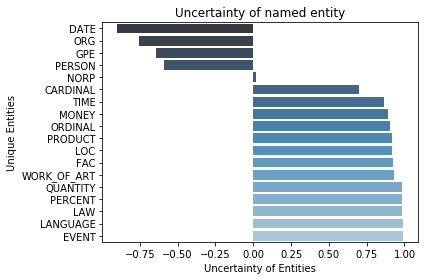

In [45]:
# enity plot
#rocket
plt.figure(figsize=(6,4))
g= sns.barplot(x=ner_des['uncertainty'],y=ner_des['entity'],palette="Blues_d")
plt.title('Uncertainty of named entity')
plt.ylabel('Unique Entities')
plt.xlabel('Uncertainty of Entities')
plt.tight_layout()

<h3><b>Information gain of all possible pair of words from without stemmed data

In [46]:
#[wordRank_withoutStem['words'='line']]

In [49]:
cnt = wordRank_withoutStem['Without_Stemming']
H_data = cnt['count'].apply(lambda x: shannon(x,cnt['count'].sum())).sum()
cnt_data = len(cnt)
def infog(H_x,H_y,cnt_x,cnt_y):
    I_xy = H_data -(cnt_x/cnt_data * H_x + cnt_y/cnt_data * H_y)
    return(I_xy)

entr_words =wordRank_exresult['Without_Stemming']

fin = []
for i in entr_words.iterrows():
    #print(i[1]['entropy'])
    #print('...')
    res = []
    for x in entr_words.iterrows():
        res.append(infog(i[1]['entropy'],x[1]['entropy'],i[1]['count'],x[1]['count']))
    fin.append(res)
    
pd.DataFrame(fin,columns=entr_words['words'].values,index=entr_words['words'].values).iloc[:5,:5]

,bioweapons,death,deaths,destroy,economy
bioweapons,9.762618,9.762618,9.762618,9.762618,9.762618
death,9.762618,9.762618,9.762618,9.762618,9.762618
deaths,9.762618,9.762618,9.762618,9.762618,9.762618
destroy,9.762618,9.762618,9.762618,9.762618,9.762618
economy,9.762618,9.762618,9.762618,9.762618,9.762618


<h3><b> Cosine similarity of each documents of with stemming and without stemming

In [50]:
#example data
a=pd.DataFrame(cosine_similarity(df_exWithoutStem, df_exWithoutStem))
b=pd.DataFrame(cosine_similarity(df_exWithStem, df_exWithStem))
a.columns = pd.MultiIndex.from_product([['With_Stemming'], a.columns])
b.columns = pd.MultiIndex.from_product([['Without_Stemming'], b.columns])

cosine_exResult = pd.concat([a, b], axis = 1)
cosine_exResult

With_Stemming                Without_Stemming               
              0    1         2                0    1         2
0      1.000000  0.0  0.142857         1.000000  0.0  0.125988
1      0.000000  1.0  0.000000         0.000000  1.0  0.000000
2      0.142857  0.0  1.000000         0.125988  0.0  1.000000

In [51]:
docs_similarity_withStem = pd.DataFrame(cosine_similarity(df_withStem, df_withStem))
docs_similarity_withStem.head()

,0,1,2,3,4,5,6,7,8,9,...,3106,3107,3108,3109,3110,3111,3112,3113,3114,3115
0,1.000000,0.087039,0.113961,0.0,0.113961,0.090909,0.083624,0.0,0.090909,0.100504,...,0.0,1.000000,0.150756,0.087039,0.087039,0.0,0.090909,0.087039,0.0,0.123091
1,0.087039,1.000000,0.109109,0.0,0.109109,0.087039,0.080064,0.0,0.087039,0.096225,...,0.0,0.087039,0.144338,0.083333,0.083333,0.0,0.087039,0.083333,0.0,0.117851
2,0.113961,0.109109,1.000000,0.0,0.285714,0.113961,0.209657,0.0,0.113961,0.125988,...,0.0,0.113961,0.188982,0.109109,0.109109,0.0,0.113961,0.218218,0.0,0.154303
3,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
4,0.113961,0.109109,0.285714,0.0,1.000000,0.113961,0.104828,0.0,0.113961,0.125988,...,0.0,0.113961,0.188982,0.109109,0.109109,0.0,0.113961,0.218218,0.0,0.154303


In [52]:
docs_similarity_withoutStem = pd.DataFrame(cosine_similarity(df_withoutStem, df_withoutStem))
docs_similarity_withoutStem.head()

,0,1,2,3,4,5,6,7,8,9,...,3106,3107,3108,3109,3110,3111,3112,3113,3114,3115
0,1.000000,0.087039,0.113961,0.0,0.113961,0.090909,0.083624,0.0,0.090909,0.100504,...,0.0,1.000000,0.150756,0.087039,0.087039,0.0,0.090909,0.087039,0.0,0.123091
1,0.087039,1.000000,0.109109,0.0,0.109109,0.087039,0.080064,0.0,0.087039,0.096225,...,0.0,0.087039,0.144338,0.083333,0.083333,0.0,0.087039,0.083333,0.0,0.117851
2,0.113961,0.109109,1.000000,0.0,0.285714,0.113961,0.104828,0.0,0.113961,0.125988,...,0.0,0.113961,0.188982,0.109109,0.109109,0.0,0.113961,0.218218,0.0,0.154303
3,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
4,0.113961,0.109109,0.285714,0.0,1.000000,0.113961,0.104828,0.0,0.113961,0.125988,...,0.0,0.113961,0.188982,0.109109,0.109109,0.0,0.113961,0.218218,0.0,0.154303


<h3><b>Calculation of conditinal Probability of each entities given by each event

Time series and Event Frequency Distribution.

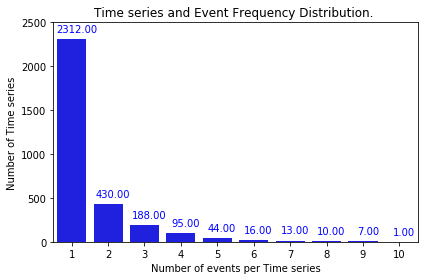

In [53]:
hashPerTweet = df['hashTag'].apply(lambda x: len(x.split(' ')))
tweet_tags = pd.DataFrame(hashPerTweet.value_counts())

plt.figure(figsize=(6,4))
g= sns.barplot(x=tweet_tags.index,y=tweet_tags['hashTag'],color='blue')

ax=g
#annotate axis = seaborn axis
for pt in ax.patches:
             ax.annotate("%.2f" % pt.get_height(), (pt.get_x() + pt.get_width() / 1.5, pt.get_height()),
                 ha='center', va='center', fontsize=10, color='blue', xytext=(0, 10),
                 textcoords='offset points')
_ = g.set_ylim(0,2500) #To make space for the annotations

plt.title('Time series and Event Frequency Distribution. ')
plt.xlabel('Number of events per Time series')
plt.ylabel('Number of Time series')
plt.tight_layout()

In [54]:
#probability of hashtags/event
cnt_tags = []
for i in utags:
    cnt_tags.append(len(df[df['text'].apply(lambda x: i in x)]))

df_tags = pd.DataFrame([utags,cnt_tags],index=['tags','count']).transpose()

total_tags  = sum(cnt_tags) #len(utags)
p_allTags = df_tags['probability'] = df_tags['count'].apply(lambda x: x/total_tags)
p_allTags

0      0.051463
1      0.008643
2      0.000786
3      0.152033
4      0.044196
         ...   
934    0.000196
935    0.000196
936    0.000196
937    0.000196
938    0.000196
Name: count, Length: 939, dtype: float64

In [55]:
#add 'black' string in empty tweet
exp_list = list(df_tags[df_tags['count']==1]['tags'])
for i in exp_list:
    df['text'] = df['text'].apply(lambda x: x +' blank' if i in x else x)

Event Frequency Distribution.

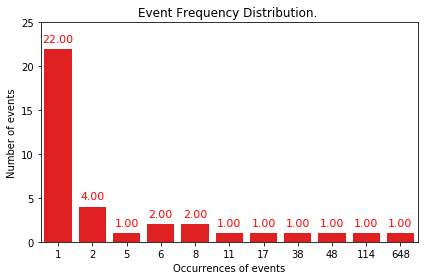

In [56]:
tags_plt = df_tags
try_tags = pd.DataFrame(tags_plt['count'].value_counts())
plt.figure(figsize=(6,4))
g= sns.countplot(x=try_tags['count'],color='red')

ax=g
#annotate axis = seaborn axis
for pt in ax.patches:
             ax.annotate("%.2f" % pt.get_height(), (pt.get_x() + pt.get_width() / 2., pt.get_height()),
                 ha='center', va='center', fontsize=11, color='red', xytext=(0, 10),
                 textcoords='offset points')
_ = g.set_ylim(0,25) #To make space for the annotations

plt.title('Event Frequency Distribution. ')
plt.xlabel('Occurrences of events')
plt.ylabel('Number of events')
plt.tight_layout()

In [57]:
#probability of words
total_w = len(df_withoutStem.iloc[:,1:].columns)
p_AllWords = df_withoutStem.iloc[:,1:].sum().apply(lambda x: x/total_w)
p_AllWords

abandon              0.000212
abbey                0.000212
abdiaziz             0.000212
abilene              0.000212
able                 0.000423
                       ...   
zoey                 0.000212
zombieapocalyptic    0.000212
zombies              0.000212
zone                 0.002538
zoom                 0.000423
Length: 4728, dtype: float64

In [58]:
#addition P(tags) + P(words)
p_add=[]
for i in p_allTags:
    p_add.append(p_AllWords.apply(lambda x: x+i))
    
prob_add = pd.DataFrame(p_add)

In [59]:
#Create dataframe of event '#corona' as example
df_tagWord = df[df['text'].apply(lambda x: '#corona' in x)]
df_tagWord.reset_index(inplace=True)
clean_data_tags =df_tagWord['text'].apply(lambda x: p.clean(x))
df_wsI,df_sI = countVect(clean_data_tags)

In [60]:
#Intersection  P(tags I word) = n(words from specific hashtag) / n(total words from all hashtags)
total_wsI = df_withoutStem.iloc[:,1:].sum().sum()
p_TagIword = []
for i in utags:
    df_tagWord = df[df['text'].apply(lambda x: i in x)]
    df_tagWord.reset_index(inplace=True)
    clean_data_tags =df_tagWord['text'].apply(lambda x: p.clean(x))
    df_wsI,df_sI = countVect(clean_data_tags)
   # print(total_wsI)
    p_TagIword.append(df_wsI.iloc[:,1:].sum().apply(lambda x: x/total_wsI))
    

prob_TagIword = pd.DataFrame(p_TagIword)
prob_TagIword.fillna(0,inplace=True)

In [61]:
#union 
comman_colms = np.intersect1d(prob_add.columns,prob_TagIword.columns)
prob_union = prob_add[comman_colms] - prob_TagIword[comman_colms]

col_add = []
col_Intr=[]
for i in prob_add.columns:
    if i not in comman_colms:
        col_add.append(i)
           
for j in prob_TagIword.columns:    
    if j not in comman_colms:
        col_Intr.append(j)
        
uni_prob = prob_union.join(prob_add[col_add]).join(prob_TagIword[col_Intr])
uni_prob = uni_prob[uni_prob.columns.sort_values().values]

Conditinal probability Result

In [62]:
#Uncertinity/ conditinal probability
#P(word/tags) = P( tags intersection word) / P(tags)

prob_uncertinity = prob_TagIword.div(p_allTags,axis=0)

prob_uncertinity.index = utags
prob_uncertinity

,action,additional,administration,advises,aid,amp,anymore,april,authorization,bhagat,...,sanitizer,images,mapping,momo,omochi,preview,projection,keeps,restarting,tractors
#…,0.00066,0.000660,0.000660,0.00066,0.00066,0.001320,0.001320,0.001320,0.00066,0.002641,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#Covid_19,0.00000,0.000000,0.000000,0.00000,0.00000,0.003931,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#CoronaVirusUpdate,0.00000,0.000000,0.000000,0.00000,0.00000,0.043245,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#coronavirus,0.00000,0.000447,0.000223,0.00000,0.00067,0.011174,0.001564,0.003576,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#COVID,0.00000,0.000000,0.000000,0.00000,0.00000,0.036903,0.000000,0.002306,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
#cities,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#inequalities…,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#MayDayStrike…,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#Bengal,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
#words/entities ranking of single event/hashtag
sample = pd.DataFrame(prob_uncertinity.iloc[40,:].sort_values(ascending=False)).head(50)
r = []
for i in range(len(sample)):
    r.append(i)

sample['Rank'] = r
sample.head()

,#ldnont,Rank
big,0.172981,0
column,0.172981,1
poised,0.172981,2
food,0.172981,3
blank,0.172981,4


In [65]:
#top ten hashtags/event
top_tags = df_tags.sort_values(by='probability',ascending=False)['tags'].head(10)

In [66]:
#Top ten words/entities of each hashtags/events
label=[]
coln=[]
val=[]
for i in range(len(prob_uncertinity)):

    s = pd.DataFrame(prob_uncertinity.iloc[i,:].sort_values(ascending=False).head(11))
    label.append(s.index)
    coln.append(s.columns)
    val.append(s.values)

top_wordsWithHash = pd.DataFrame(label,index=pd.DataFrame(coln).values).transpose()

In [67]:
#top_wordsWithHash[[top_tags]]#.iloc[1:,:]

In [69]:
pd.DataFrame(list(map(np.ravel, val)),index=pd.DataFrame(coln).values).transpose()[[top_tags]].iloc[1:,:]

,"(#corona,)","(#coronavirus,)","(#Corona,)","(#Coronavirus,)","(#…,)","(#COVID,)","(#COVID19,)","(#CoronaVirus,)","(#Covid_19,)","(#covid,)"
1,0.021952,0.022125,0.020408,0.024288,0.161757,0.036903,0.051456,0.045125,0.090422,0.029533
2,0.015805,0.016091,0.017978,0.021919,0.161097,0.028446,0.039413,0.037605,0.090422,0.029533
3,0.013171,0.013409,0.017978,0.021326,0.161097,0.026139,0.033939,0.030084,0.090422,0.025314
4,0.012732,0.012739,0.017492,0.021326,0.161097,0.023064,0.032844,0.022563,0.090422,0.021095
5,0.012074,0.012292,0.017492,0.020734,0.161097,0.020758,0.025181,0.022563,0.090422,0.016876
6,0.011195,0.011174,0.017007,0.020734,0.161097,0.017682,0.024086,0.022563,0.090422,0.016876
7,0.010098,0.010281,0.016035,0.019549,0.161097,0.014607,0.020801,0.022563,0.062902,0.012657
8,0.009000,0.009163,0.014577,0.017772,0.161097,0.013838,0.019707,0.022563,0.047177,0.012657
9,0.008122,0.008269,0.014577,0.017180,0.161097,0.013838,0.019707,0.022563,0.047177,0.012657
10,0.008122,0.008269,0.014091,0.016587,0.008583,0.013838,0.018612,0.018802,0.047177,0.012657


<h3><b>Top words/entities from all events using Uncertinity score

<b>Mathamatical Foundation

<green>Example
    

us|#corona = 0.021951887120645434 = P(word)interP(us)/P(word)
#corona = total words = 2015  P(word) = 1/2015  
Word “us” in #corona = 100 = P(us) 1/100
 
Entropy = H  = -1/2015*log2(2015)-1/100*log2(100)-0.021951887120645434*log2(1/0.021951887120645434)) = -0.19283015668933684

IG(i) = H*1/c(i) =  -0.0019283015668933685
    
UN (A) = 1-IG = 1.0019283015668934


In [70]:
#uncertinity
con_prob = prob_uncertinity.transpose()
tot = []
totE = []
totI = []

def unc(i,x,t_words,colm):
    global COUNT
    c_prob = con_prob[i].loc[colm[COUNT]]
    s_word = x
    
    E  = -1/t_words * log2(t_words) - 1/s_word * log2(s_word) - c_prob * log2(1/c_prob)
   # print(E)
    ig = E * 1/s_word
    un = 1- ig
    COUNT = COUNT+1
    #print(COUNT)
    return un

def entr(i,x,t_words,colm):
    global COUNT
    c_prob = con_prob[i].loc[colm[COUNT]]
    s_word = x
    E  = -1/t_words * log2(t_words) - 1/s_word * log2(s_word) - c_prob * log2(1/c_prob)
    COUNT = COUNT+1
    #print(COUNT)
    return E

def inf(i,x,t_words,colm):
    global COUNT
    c_prob = con_prob[i].loc[colm[COUNT]]
    s_word = x
    
    E  = -1/t_words * log2(t_words) - 1/s_word * log2(s_word) - c_prob * log2(1/c_prob)
   # print(E)
    ig = E * 1/s_word
    COUNT = COUNT+1
    #print(COUNT)
    return ig

for i in utags:
    df_tagWord = df[df['text'].apply(lambda x: i in x)]
    df_tagWord.reset_index(inplace=True)
    clean_data_tags =df_tagWord['text'].apply(lambda x: p.clean(x))
    df_wsI,df_sI = countVect(clean_data_tags)
    t_words = len(df_wsI.iloc[:,1:].columns)
    un_tot = []
    
    COUNT = 0
    tot.append(df_wsI.iloc[:,1:].sum().apply(lambda x: unc(i,x,t_words,df_wsI.iloc[:,1:].columns)))
    COUNT = 0
    totE.append(df_wsI.iloc[:,1:].sum().apply(lambda x: entr(i,x,t_words,df_wsI.iloc[:,1:].columns)))
    COUNT = 0
    totI.append(df_wsI.iloc[:,1:].sum().apply(lambda x: inf(i,x,t_words,df_wsI.iloc[:,1:].columns)))
    
unc_hashWord = pd.DataFrame(tot)
unc_hashWord.fillna(0,inplace=True)

uncE_hashWord = pd.DataFrame(totE)
uncE_hashWord.fillna(0,inplace=True)

uncI_hashWord = pd.DataFrame(totI)
uncI_hashWord.fillna(0,inplace=True)

#uncertantiy
unc_hashWord.index = utags
uncE_hashWord.index = utags
uncI_hashWord.index = utags
unc_hashWord

,action,additional,administration,advises,aid,amp,anymore,april,authorization,bhagat,...,sanitizer,images,mapping,momo,omochi,preview,projection,keeps,restarting,tractors
#…,1.064915,1.064915,1.064915,1.064915,1.064915,1.285285,1.285285,1.285285,1.064915,1.14514,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#Covid_19,0.000000,0.000000,0.000000,0.000000,0.000000,1.082630,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#CoronaVirusUpdate,0.000000,0.000000,0.000000,0.000000,0.000000,1.381712,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#coronavirus,0.000000,1.255289,1.008315,0.000000,1.180331,1.003819,1.060177,1.017792,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#COVID,0.000000,0.000000,0.000000,0.000000,0.000000,1.006344,0.000000,1.187007,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
#cities,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#inequalities…,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#MayDayStrike…,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#Bengal,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
#example
ex = df[df['text'].apply(lambda x: '#corona' in x)]
ex.reset_index(inplace=True)
cleanEX_data_tags =ex['text'].apply(lambda x: p.clean(x))
ex_wsI,ex_sI = countVect(cleanEX_data_tags)

word_sum = ex_wsI['wuhan'].sum()
wordsINhastag = len(ex_wsI.iloc[:,1:].columns)
conditinal_prob = con_prob['#corona']['wuhan']

In [73]:
entr = -(1/wordsINhastag*log2(wordsINhastag) + 1/word_sum*log2(word_sum) + conditinal_prob*log2(1/conditinal_prob)) #* (1/100)
igs = entr * (1/100)
unc = 1-igs
uncE_hashWord['wuhan']['#corona']

-0.1972836252848375

In [74]:
#Top ten words/entities of each hashtags/events
label=[]
coln=[]
val=[]
for i in range(len(unc_hashWord)):

    s = pd.DataFrame(unc_hashWord.iloc[i,:].sort_values(ascending=True).head(30))
    label.append(s.index)
    coln.append(s.columns)
    val.append(s.values)

top_CwordsWithHash = pd.DataFrame(label,index=pd.DataFrame(coln).values).transpose()

<b>Top ten entities of respective Events

In [76]:
forplt = top_CwordsWithHash[[top_tags]]
forplt[:10]

,"(#corona,)","(#coronavirus,)","(#Corona,)","(#Coronavirus,)","(#…,)","(#COVID,)","(#COVID19,)","(#CoronaVirus,)","(#Covid_19,)","(#covid,)"
0,tractors,action,action,action,spreading,action,action,action,action,action
1,normal,lethal,watching,allout,street,fragme,cw,veritastipscom,street,alarming
2,officials,life,waveits,alpha,urgently,freakout,debt,visit,urgently,allow
3,ol,lillah,ways,americathere,washington,frida,deep,vows,washington,ambassador
4,ons,listen,weak,analyses,demands,fries,defend,vroom,demands,american
5,oppose,listened,weapon,appointments,hanoi,frozen,deserves,warned,hanoi,amount
6,outbreakhtt,loaders,wearing,assist,jane,fudge,direct,wed,jane,angeles
7,outbreaks,local,wednes,barbara,yeahnomaybe,function,disappeared,weight,yeahnomaybe,apology
8,overpriced,lockdownno,weekend,bayi,abou,gal,discuss,welcome,abou,austral
9,overthetop,less,weil,airline,aboutunemployment,gangs,disinfecting,weldone,aboutunemployment,avidly


In [77]:
#pd.DataFrame(list(map(np.ravel, val)),index=pd.DataFrame(coln).values).transpose()[[top_tags]].iloc[1:,:]

<b>Result of top 30 ranked entities of four events 

In [80]:
from wordcloud import WordCloud
from math import ceil

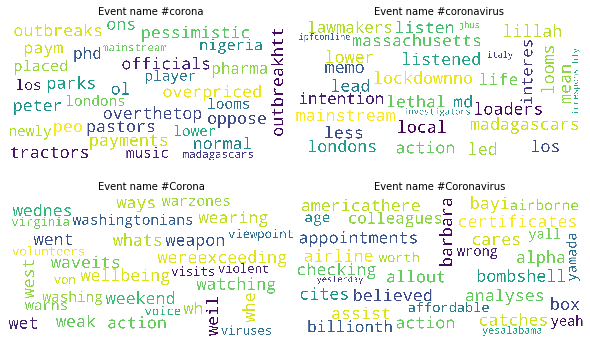

In [81]:
#Top 30 words/entities of each hashtags/events
ncol=2
n_clust =4
nrows=ceil(n_clust/ncol)
fig, axeslist = plt.subplots(ncols=ncol,nrows=nrows, figsize=(8,5))
for i in range(4):
    name = []
    event_words = ' '.join(list(forplt.iloc[:,i].values))
    word_cloud = WordCloud(background_color='white',
                           max_words=100,
                           max_font_size=23,
                           scale=6,
                           random_state=1).generate(event_words)

    name.append(str(forplt.columns[i]).split("'")[1])
    axeslist.ravel()[i].imshow(word_cloud)
    axeslist.ravel()[i].set_title(f'Event name {name[0]}',fontsize=10)
    axeslist.ravel()[i].set_axis_off()
        
plt.tight_layout(pad = 0) 
plt.show()